**Train Random Forest Model**
* Get the 3 sets of data from EDA
* Train default RandomForest Models
* Perform Random Search for best parameters
* Remove less important features
* Evaluate the models

1. import Python packages and training data

In [88]:
# adding required libraries
import pandas as pd
import numpy as np

2. Load the dataset for model training

In [89]:
# Load the data from csv
x_data_org =pd.read_csv('../data/interim/x_data_org.csv')
y_data_org =pd.read_csv('../data/interim/y_data_org.csv')
x_data_eda =pd.read_csv('../data/interim/x_data.csv')
y_data_eda =pd.read_csv('../data/interim/y_data.csv')
x_balanced_data =pd.read_csv('../data/interim/x_balanced_data.csv')
y_balanced_data =pd.read_csv('../data/interim/y_balanced_data.csv')

x_test_org =pd.read_csv('../data/interim/x_test_org.csv')
y_test_org =pd.read_csv('../data/interim/y_test_org.csv')
x_test_eda =pd.read_csv('../data/interim/x_test.csv')
y_test_eda =pd.read_csv('../data/interim/y_test.csv')
x_balanced_test =pd.read_csv('../data/interim/x_balanced_test.csv')
y_balanced_test =pd.read_csv('../data/interim/y_balanced_test.csv')


3. Set up baseline model

In [90]:
# find the most occuring value and use it as base model
y_mode = y_data_org.mode()
y_shape = (len(x_data_org), 1)
y_base = np.full(y_shape, y_mode)

In [91]:
# calculate the accuracy score of the base model
from sklearn.metrics import accuracy_score
accuracy_score(y_data_org, y_base)

0.833125

4. Train Random Forest model

In [92]:
from sklearn.ensemble import RandomForestClassifier
datasets = [(x_data_org, y_data_org, x_test_org, y_test_org), (x_data_eda, y_data_eda, x_test_eda, y_test_eda), (x_balanced_data, y_balanced_data, x_balanced_test, y_balanced_test)]
models = []

for i, (x, y, x_test, y_test) in enumerate(datasets):
    rf_model = RandomForestClassifier(random_state=8)
    rf_model.fit(x, y.values.ravel())
    models.append(rf_model)
    print(f'Training score for dataset {i+1}: {rf_model.score(x, y)}')
    print(f'Test score for dataset {i+1}: {rf_model.score(x_test, y_test)}')
    print('\n')

# Accessing the models
rf_model_org = models[0]
rf_model = models[1]
rf_model_balanced = models[1]


Training score for dataset 1: 1.0
Test score for dataset 1: 0.83125


Training score for dataset 2: 1.0
Test score for dataset 2: 0.8369803063457331


Training score for dataset 3: 1.0
Test score for dataset 3: 0.6175438596491228




5. Perform grid search for optimised parameters

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

best_params_list = []

# Perform RandomizedSearchCV for each dataset
for i, (x, y, x_test, y_test) in enumerate(datasets):
    rf = RandomForestClassifier(random_state=8)
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=8)
    random_search.fit(x, y.values.ravel())
    best_params = random_search.best_params_
    best_params_list.append(best_params)
    print(f"Best parameters for dataset {i+1} using RandomizedSearchCV: {best_params}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for dataset 1 using RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for dataset 2 using RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for dataset 3 using RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}


In [96]:
# For each dataset, use the best parameters to train a new model and evaluate its performance
best_models = []
for i, (x, y, x_test, y_test) in enumerate(datasets):
    best_params = best_params_list[i]
    rf_model = RandomForestClassifier(**best_params, random_state=8)
    rf_model.fit(x, y.values.ravel())
    best_models.append(rf_model)
    print(f'Training score for dataset {i+1}: {rf_model.score(x, y)}')
    print(f'Test score for dataset {i+1}: {rf_model.score(x_test, y_test)}')

Training score for dataset 1: 0.9975
Test score for dataset 1: 0.83
Training score for dataset 2: 0.8459644322845418
Test score for dataset 2: 0.8413566739606126
Training score for dataset 3: 0.7129060579455663
Test score for dataset 3: 0.6456140350877193


5. Check feature importance

In [101]:
# get feature importance
for i, model in enumerate(best_models):
    # get feature importance
    feature_importance = model.feature_importances_

    # create a dataframe for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': datasets[i][0].columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # display the feature importance
    print(f"Feature importance for model {i+1}:")
    print(feature_importance_df)


Feature importance for model 1:
    Feature  Importance
0        GP    0.094325
5       FG%    0.074101
8       3P%    0.069154
11      FT%    0.067265
1       MIN    0.064910
2       PTS    0.054932
14      REB    0.051969
4       FGA    0.051202
7       3PA    0.050867
13     DREB    0.047924
15      AST    0.047891
10      FTA    0.046150
3       FGM    0.044414
12     OREB    0.042961
9       FTM    0.041702
18      TOV    0.041614
17      BLK    0.038447
6   3P Made    0.035165
16      STL    0.035007
Feature importance for model 2:
    Feature  Importance
0        GP    0.244560
5       FG%    0.116052
1       MIN    0.081062
14      REB    0.074544
9       FTM    0.052220
13     DREB    0.049337
8       3P%    0.048800
2       PTS    0.047481
11      FT%    0.043006
10      FTA    0.033364
12     OREB    0.033216
18      TOV    0.032081
3       FGM    0.027466
7       3PA    0.025852
17      BLK    0.021851
4       FGA    0.020281
15      AST    0.020128
16      STL    0.016614


In [111]:
# Drop features with importance less than 0.02 for each model
threshold = 0.05
datasets_filtered = []

for i, (x, y, x_test, y_test) in enumerate(datasets):
    model = best_models[i]
    feature_importance = model.feature_importances_
    important_features = x.columns[feature_importance >= threshold]
    x_filtered = x[important_features]
    datasets_filtered.append((x_filtered, y, x_test[important_features], y_test))
    print(f"Dataset {i+1} filtered features:")
    print(important_features)

Dataset 1 filtered features:
Index(['GP', 'MIN', 'PTS', 'FGA', 'FG%', '3PA', '3P%', 'FT%', 'REB'], dtype='object')
Dataset 2 filtered features:
Index(['GP', 'MIN', 'FG%', 'FTM', 'REB'], dtype='object')
Dataset 3 filtered features:
Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', 'FTM', 'FTA', 'FT%', 'OREB',
       'REB'],
      dtype='object')


In [112]:
# Train and evaluate a model for each filtered dataset using the best parameters
filtered_best_models = []

for i, (x, y, x_test, y_test) in enumerate(datasets_filtered):
    best_params = best_params_list[i]
    rf_model = RandomForestClassifier(**best_params, random_state=8)
    rf_model.fit(x, y.values.ravel())
    filtered_best_models.append(rf_model)
    print(f'Training score for filtered dataset {i+1}: {rf_model.score(x, y)}')
    print(f'Test score for filtered dataset {i+1}: {rf_model.score(x_test, y_test)}')

Training score for filtered dataset 1: 0.9946875
Test score for filtered dataset 1: 0.83
Training score for filtered dataset 2: 0.8451436388508892
Test score for filtered dataset 2: 0.8413566739606126
Training score for filtered dataset 3: 0.7032484635645303
Test score for filtered dataset 3: 0.6456140350877193


6. Seems the model using EDA dataset and best parameters and reduced features is the best model. Exam the model with diagrams

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

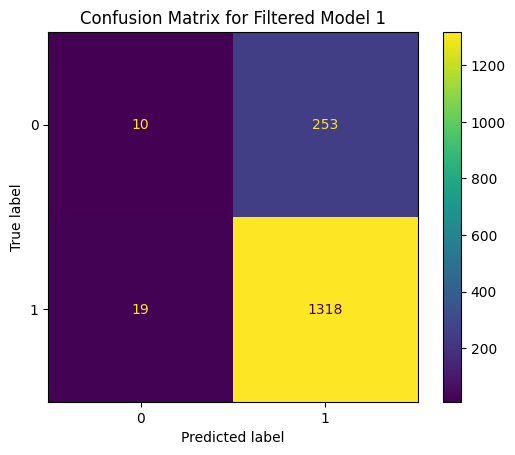

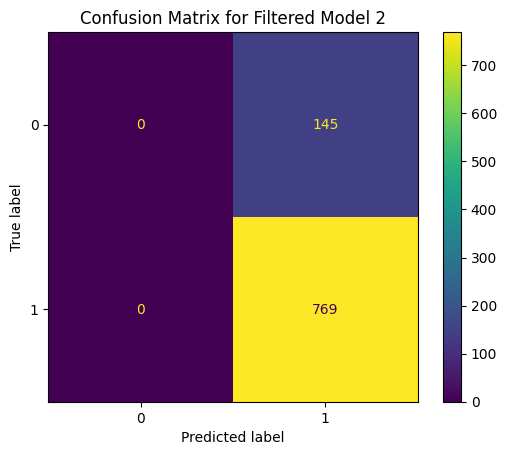

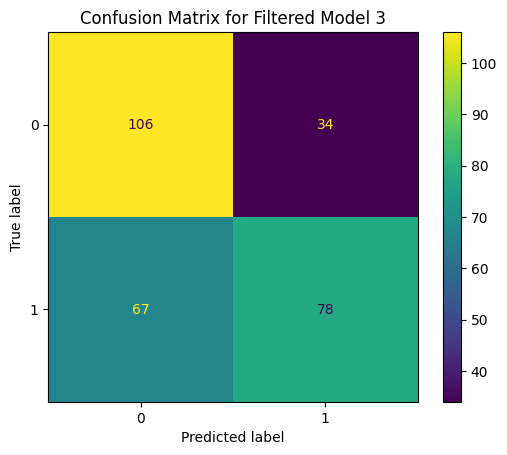

In [121]:
# Evaluate each model in filtered_best_models using ConfusionMatrixDisplay
for i, (x, y, x_test, y_test) in enumerate(datasets_filtered):
    model = filtered_best_models[i]
    y_pred = model.predict(x_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix for Filtered Model {i+1}')
    plt.show()

6. Conclusion
This is a better model compare to SVM model, but the accuracy is not high enough. 

7. Export Model

In [67]:
import joblib

# Export the Random Forest model
joblib.dump(best_models[0], '../models/rf_model.pkl')

['../models/rf_model.pkl']